# Naive Ascent Algorithm
Daniel Alejandro Alonso Bastos

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time

## Descripción de funciones

El primer paso es que el usuario ingrese la ruta del archivo txt o csv con los datos a procesar, junto con el separador. La función que lee los datos y los transforma a un array es la función _readData._ Nótese que para que el programa funcione es necesario que la estrcutura sea $x_1,x_2,...,x_n,f(x_1,x_2,...,x_n)$. Es decir, las primeras columnas son las variables independientes y la última columna es la variable dependiente.

In [2]:
def readData(path,delimiter='tab'):
    '''
    Funcion leer un archivo y hacer la separacion por tabulador si el usuario ingresa 'tab' o coma ','
    Nota: No soporta UTF-8
    
    Inputs:
    paht: str - Ruta del archivo a leer
    delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
    
    Return
    data: array - Estructura de tipo array para manipular los datos 
    '''
    try:
        if delimiter == 'tab':
            data = np.genfromtxt(path,delimiter='\t')
        elif delimiter == ',':
            data = np.genfromtxt(path,delimiter=',')     
        return data
    except:
        print('El separador seleccionado no es compatible')

La función _sortDataDistance_ ordena los datos de manera descendiente en función de la distancia euclidiana de las $x_n$ variables al origen, de tal manera que se seleccionen las primeras $M$ tuplas con el objetivo de tener un error de arranque lo más grande posible.

In [3]:
def sortDataDistance(data):
    '''
    Funcion que ordena el conjunto de datos 'data' de manera descendente en funcion de la distancia euclidiana
    de las variables respecto al origen
    
    Input:
    data: array - Conjunto de datos que se quieren ordenar
    
    Return:
    data_sort: array - Conjunto de datos ordenados de la misma dimension que data, i.e., no se guarda
        la distancia calculada
    '''
    # obtener dimensiones de la data original
    rows,columns = data.shape
    # inicializar arreglo auxiliar para calcular la distancia (agregar una columna)
    data_distance = np.zeros((rows,columns+1))
    # colocar valores de data en el arreglo (en las primeras columnas)
    data_distance[:,:columns] = data
    # calcular distancia desde el origen (la ultima columna es f, y las demas son variables)
    for i in range(rows):
        distance = np.sqrt(np.sum(np.square(data[i][:columns-1])))
        data_distance[i,-1] = distance # guardar distancia en la ultima columna
    # ordenar de mayor a menor con respecto a la distancia (ultima fila)
    data_sort = data_distance[data_distance[:,-1].argsort()[::-1]]
    # eliminar columna de distancia
    return data_sort[:,:columns]

La función _introducePerturbation_ le introduce una ligera perturbación del orden $\delta_H$ a los datos, tal que:

\begin{equation}
    X_i^* =
    \left\{\begin{matrix}
        X_i \times (1+\rho_u\cdot\delta_H) & if & X_i\neq 0\\ 
        \rho_u\cdot\delta_H & if & X_i=0 
    \end{matrix}\right.
\end{equation}

donde $X_i^*$ es el nuevo valor con una ligera perturbación, $X_i$ es el valor actual, $\rho_u \in [0,1]$ es un número aleatorio y $\delta_H$ es el factor de perturbación.

In [4]:
def introducePerturbation(data,factor=1/1e6):
    '''
    Funcion que agrega una perturbacion del orden de factor a un conjunto de datos
    
    Input:
    data: array - Conjunto de datos al que se le quiere agregar una perturbacion
    factor: float - Factor de perturbacion
    
    Return:
    data_noise: array - Conjunto de datos con perturbacion
    
    '''
    # crear una mascara para realizar operaciones a valores iguales y distintos a cero
    data_noise = data.copy()
    ## para valores distintos a cero
    mask = data_noise!=0
    data_noise[mask] = data_noise[mask]*(1+random.random()*factor)
    ## para valores iguales a cero
    mask = data_noise==0
    data_noise[mask] = data_noise[mask]+(random.random()*factor)
    
    return data_noise

La función _coefficientCombination_ genera la combinación de los exponentes que tendrán las variables para hasta 4 variables en el rango $n$ que defina el usuario. P.ej., si el usuario ingresa la lista $[1,1,1]$ la función regresa la combinación de los exponenetes tal que $[000,001,010,011,100,101,110,111]$.

In [5]:
def coefficientCombination(degree_variables):
    '''
    Funcion para generar una lista con la combinacion de exponentes que tendran los coeficientes
    Nota: La funcion solo soporta hasta 4 variables
    
    Inputs:
    degree_variables: list - Lista con el valor maximo del exponente por variable
        P.ej., [1,2,3] significa que la variable x1->[0,1],x2->[0,2],x3->[0,3]
    
    Return
    coef_comb: list - Lista con las combinaciones
    '''
    n = len(degree_variables) # numero de variables
    degree_arr = np.array(degree_variables) + 1
    coef_comb = [] # inicializar lista para guardar combinaciones
    if n == 1: # para 1 variable
        for i in range(degree_arr[0]):
            coef_comb.append(str(i))
    if n == 2: # para 2 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                coef_comb.append(str(i)+str(j))
    if n == 3: # para 3 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                for k in range(degree_arr[2]):
                    coef_comb.append(str(i)+str(j)+str(k))
    if n == 4: # para 4 variables
        for i in range(degree_arr[0]):
            for j in range(degree_arr[1]):
                for k in range(degree_arr[2]):
                    for l in range(degree_arr[3]):
                        coef_comb.append(str(i)+str(j)+str(k)+str(l))
    return coef_comb

La función _generateEquationSystem_ genera el siguiente sistema de ecuaciones:

\begin{equation}
\begin{bmatrix}
\sigma_1 & X_{11} & X_{12} & \cdots & X_{1m}\\ 
\sigma_2 & X_{21} & X_{22} & \cdots & X_{2m} \\ 
\vdots  & \vdots & \vdots & \vdots & \vdots \\ 
\sigma_M & X_{M1} & X_{M2} & \cdots & X_{Mm} 
\end{bmatrix}
\begin{bmatrix}
\epsilon_\theta\\ 
c_1\\ 
c_2\\ 
\vdots\\ 
c_M
\end{bmatrix} = 
\begin{bmatrix}
f_1\\ 
f_2\\ 
\vdots\\ 
f_M
\end{bmatrix}
\end{equation}

donde:
- $\sigma_i = (-1)^{i+1}sgn(\Delta_{i'})$, $\sigma_i$ es el signo de los determinantes, y $\Delta_{i'}$ representa el determinante al eliminar la primera columna y la $i$-ésima fila de la matriz.
- $m$ es el número de variables independientes.
- $M$ es el número de variables independientes más el error, tal que $M=m+1$
- $\epsilon_\theta$ es el error del conjunto interno, que se busca minimizar.
- $c_i$ es el valor de los $m$ coeficientes.

Como primer paso, se calculan los valores de los signos $\sigma_i$ (de la primera columna de la matriz $A$), para ello se pueden realizar distintas estrategias:

- Cálculo explícito del signo de cada uno de los determinantes.
- Cálculo explícito del signo de un determinante, y los demás con ayuda del teorema de cofactores.
- Fijar de manera arbitraria el signo, dad la suposición de que la suma de los cofactores es 1.
- Asumir que el signo de un cofactor es -1, y calcular los demás con ayuda del teorema de cofactores.
- Calcular la matriz inversa de $A$. Los signos en la primera columna corresponden a los signos minimax.

En la función _generateEquationSystem_ se tiene el parámetro _method_ que indica el método por el que se quiere calcular los signos, teniendo la opción de utilizar el primer método _det_ que toma $O(m^4)$ o el cuarto método _indirect_COT_ que toma $O(m^2)$

In [6]:
def generateEquationSystem(inner_set, coef_comb, method = 'indirect_COT'):
    '''
    Funcion para generar el sistema de ecuaciones Ax=b para resolverlo y obtener el error e_theta y 
    el valor de los coficientes. Para ello el primer paso es generar la matriz A de tamanio MXM
    donde se tienen la primer columna de los signos sigam y las m variables independientes evaluadas 
    segun la combinacion del grado del exponente.
    
    Una vez calculada, se calculan los signos ya sea por el metodo de determinantes, o el de suponer el
    valor de un signo y resolver el SE, de esta manera ya se tiene la matriz A (A_matrix) completa.
    
    Despues se calcula el vector b (b_vector) que corresponde a la ultima columan del conjunto interno (inner_set)
    
    Inputs:
    inner_set: array - Conjunto interno de datos (primeros M vectores)
    coef_comb: list - lista con las distintas combinaciones de los exponentes
    method: str - 'det' para realizar el calculo de los signos al realizar el calculo de todos los determinantes O(m^4)
                  'indirect_COT' para realizarlo al suponer un signo de cun cofactor y despues resolver el SE O(m^2)
                  
    Returns:
    A_matrix: array - Matriz A del SE, con la columna de signos calculada
    b_vector: array - Vector con los terminos dependientes
    sign_list: array- Arreglo con los signos resultantes
    '''
    # crear sistema de ecuaciones
    #Mx(1+m), la primera columna es para calcular los determinantes
    #las demas columnas son las combinaciones de los coeficientes (coef_comb)
    M,columns = inner_set.shape
    n_variables = columns-1
    A_matrix = np.zeros((M,M)) 
    for row in range(M):# para cada fila
        for column in range(1,M):
            coef = 1 #inicializar
            for i in range(n_variables): #iterar sobre las variables del dataset original
                grade = coef_comb[column-1][i] #recuperar str con el exponente de la variable segun la combinacion
                coef *= inner_set[row,i]**int(grade)#multiplicar las variables elevadas con su respectivo exponente
            A_matrix[row,column] = coef# actualizar valores

    # calcular signo de determinantes de la primera columna
    if method == 'det':
        ## metodo 1 calcular los determinantes de cada renglon
        for i in range(M):
            A_matrix[i,0] = (-1)**(i)*np.sign(np.linalg.det(np.delete(A_matrix,i,0)[:,1:]))
        # obtener lista de signos
        sign_list = A_matrix[:,0]

    if method == 'indirect_COT':
        ## metodo indirecto (tipo 2), el valor del M-esimo cofactor es igual a -1 y se resuelve el SE
        # transponer matriz sin la columna de los signos
        aux_matrix = A_matrix[:,1:].T
        # dejar el valor del m-esimo cofactor =-1
        mth_cofactor = -1
        # separar la matriz A (M-1 columnas) y el vector b (ultima columna) para resolver el SE 
        A_solve = aux_matrix[:,:-1]
        b_solve = mth_cofactor*-aux_matrix[:,-1]
        # resolver SE y obtener los signos
        sign_list = np.sign(np.linalg.solve(A_solve,b_solve))
        # agregar m-esimo cofactor
        sign_list = np.append(sign_list,mth_cofactor)
        # actualizar columna de signos de la matriz A_matrix
        A_matrix[:,0] = sign_list

    # obtener vector b
    b_vector = inner_set[:,-1]
    
    return A_matrix, b_vector, sign_list

La función _get_e_phi_ calcula el error de un conjunto de datos, siendo $\epsilon_\phi$ el error del conjunto de datos externo. Siendo:

\begin{equation}
    \epsilon_i = |f_i-y_i|,~~\epsilon_\phi=max(\epsilon_1,\cdots,\epsilon_N)
\end{equation}

In [7]:
def get_e_phi(outer_set,m,coef_comb,solution_coef):
    '''
    Funcion para calcular el error e_phi del conjunto externo, ademas de identificar el indice donde se encuentra
    el valor maximo, y los resultados y_i al utilizar los coeficientes de una lista
    
    Inputs:
    outer_set: array - Conjunto externo de datos (tambien se puede emplear cualquier conjunto para calcular y_i)
    m: int - numero de variables independientes
    coef_comb: list - Lista con las combinaciones
    solution_coef: array - Arreglo con el valor de los coeficientes
    
    Return:
    e_phi: float - Valor del error maximo en el conjunto al realizar |f_i-y_i|
    e_phi_idx: int - Indice donde se encuentra el error maximo e_phi
    y_i: array - Arreglo con los valores de y_i al utilizar los coeficientes en solution_coef
    '''
    # calcular dimensiones del conjunto externo
    rows,columns = outer_set.shape
    n_variables = columns-1 # numero de variables
    
    # inicializar matriz con la combinacion de coeficientes
    comb_matrix = np.zeros((rows,m))
    
    # iterar para cada fila del conjunto externo
    for row in range(rows):
        for column in range(m): #iterar para cada combinacion de grados
            coef = 1 #inicializar
            for i in range(n_variables): #iterar sobre las variables del dataset original
                grade = coef_comb[column][i] #recuperar str con el exponente de la variable segun la combinacion
                coef *= outer_set[row,i]**int(grade)
            # actualizar valores de la matriz de combinaciones
            comb_matrix[row,column] = coef
    
    # realizar producto punto entre la matriz de combinaciones y el arreglo con el valor de los coeficientes para calcular y_i
    y_i = np.dot(comb_matrix,solution_coef)
    # calcular vector de errores e_i
    e_i = np.abs(outer_set[:,-1] - y_i)
    # calcular el error maximo e_phi y el indice donde se encuentra
    e_phi = np.max(e_i)
    e_phi_idx = np.argmax(e_i)
    
    return e_phi, e_phi_idx, y_i

La función _swapVectors_ realiza el intercambio de 1 vector en los conjuntos internos y externos respectivamente.

In [8]:
def swapVectors(inner_set,inner_idx,outer_set,outer_idx):
    '''
    Funcion para realizar el intercambio de 1 vector en 2 conjuntos de datos
    
    Inputs:
    inner_set: Conjunto interno (puede ser cualquier otro conjunto)
    inner_idx: Indice del conjunto interno a intercambiar
    outer_set: Conjunto externo (puede ser cualquier otro conjunto)
    outer_idx: Indice del conjunto externo a intercambiar
    
    Return:
    arr1, arr2: array - Conjunto interno y externo con los vectores intercambiados
    '''
    # crear copias apra evitar conflictos de referencia
    arr1 = inner_set.copy()
    arr2 = outer_set.copy()
    # cambiar valores
    aux_copy = arr1[inner_idx,:].copy()
    arr1[inner_idx,:] = arr2[outer_idx,:]
    arr2[outer_idx,:] = aux_copy
    return arr1, arr2

La función _solver_ es la encargada de ejecutar el algoritmo hasta cumplir con el criterio de convergencia:

\begin{equation}
\epsilon_\theta(t)\geq \epsilon_\phi(t)
\end{equation}

Realiza los siguientes pasos hasta llegar a la convergencia:

- Intercambiar vector $i$ del conjunto interno con el vector $k$ del conjunto externo.
- Resuelve los signos y genera el sistema de ecuaciones $Ax=b$
- Resuelve el SE.
- Verifica que el error $\epsilon_\theta$ sea ascendete tal que $\epsilon_\theta(t,i)>\epsilon_\theta(t-1,i)$. En caso de que se cumpla:

    - Calcular $\epsilon_\phi$ y su respectivo índice
    - Si $\epsilon_\theta(t)\geq \epsilon_\phi(t)$ se cumple el criterio de convergencia finaliza la ejecución del _solver_.
    - En caso de que no se cumpla, se actualiza el tiempo $t=t+1$ y se comienza el siguiente paso de tiempo.

- En caso de que no se cumpla $\epsilon_\theta(t,i)>\epsilon_\theta(t-1,i)$ se intercambia el sigueinte vector $i$ para ver si cumple con la condición.


En cada paso de tiempo se guarda en una lista $[t,\epsilon_\theta,\epsilon_\phi]$.

In [9]:
def solver(inner_set,outer_set,e_phi,e_phi_idx,e_theta,coef_comb,method):
    '''
    Funcion que ejecuta el algoritmo hasta cumplir con el criterio de convergencia. El paso inicial se realiza en
    la funcion principal NAA.
    
    Inputs:
    inner_set: array - Conjunto interno de datos
    outer_set: array - Conjunto externo de datos
    e_phi: float - Error maximo en el conjunto externo de datos en el paso inicial
    e_phi_idx: int - Indice donde se encuentra el error maximo e_phi
    e_theta: float - e_theta del paso inicial
    coef_comb: list - Lista con las combinaciones
    method: str - metodo para calcular los signos en el SE ('det'/'indirect_COT')
    
    Return:
    solution: array - Arreglo con los valores de e_theta y los m coeficientes
    residuals: list - lista con el registro de los residuales [t,e_theta,e_phi]
    '''
    
    i=0 # inicializar indice
    run = True # inicializar bandera de paro
    t=0 # inicializar tiempo
    residuals = [] # inicializar lista para guardar valores de residuales [t,e_theta,e_phi]
    m = len(coef_comb) # numero de variables independientes para calcular
    # ejecutar hasta encontrar solucion
    while run:
        # en caso de recorrer todo el conjunto, comenzar
        if i >= inner_set.shape[0]: i=0
        # intercambiar vector i del conjunto interno con el vector k del conjunto externo
        inner_set, outer_set = swapVectors(inner_set,i,outer_set,e_phi_idx)
        #print(f'{i},{e_phi_idx},{e_phi}')
        # generar sistema de ecuaciones Ax=b (calcular los signos de error)
        A_matrix, b_vector, sign_list = generateEquationSystem(inner_set, coef_comb, method = method)
        # obtener e_theta para el nuevo conjunto interno
        solution = np.linalg.solve(A_matrix,b_vector)
        e_theta_t = solution[0]
        # revisar que e_theta ascienda (e_theta(t+1)>e_theta(t))
        if e_theta_t>e_theta:
            # encontrar e_phi del conjunto externo junto con el indice
            e_phi, e_phi_idx, y_i = get_e_phi(outer_set,m,coef_comb,solution[1:])
            # revisar condicion de convergencia
            if e_theta_t>=e_phi:
                # terminar ejecucion
                run = False
            else:
                # en caso de no cumplir convergencia, empezar
                e_theta = e_theta_t # actualiza el nuevo valor de e_theta(t)
                i=0 # inicializar i
        else:
            # en caso de no cumplir e_theta(t+1)>e_theta(t) probar con otro vector del conjunto interno
            i+=1
            # regresar arreglo original del t-1
            if i != inner_set.shape[0]: inner_set, outer_set = swapVectors(inner_set,i-1,outer_set,e_phi_idx)
            
        t+=1 #incrementar paso de tiempo
        residuals.append([t,e_theta,e_phi]) #agregar resultados del paso actual

    return solution,residuals

La función _NAA_ es la función principal, es la encargada de ejecutar todo el algoritmo de __Naive Ascent Algorithm__, al realizar los siguientes pasos:

- Leer el archivo, se ejecuta la función __readData__
- Seleccionar los $M$ vectores equidistantes (opcional al usuario), se ejecuta la función __sortDataDistance__
- Realizar una ligera perturbación a los datos (opcional al usuario), se ejecuta la función __introdocePerturbation__
- Generar la combinación de los exponentes de las variables, se ejecuta la función __coefficientCombination__
- Calcular los parámetros importantes para realizar la ejecución del _solver_.
- Realizar el paso inicial del algoritmo:
    - Obtener el sistema de ecuaciones con los signos $\sigma_i$ resueltos, se ejecuta la función __generateEquationSystem__
    - Resolver sistema de ecuaciones, se ejecuta la función __np.linalg.solve__
    - Calcular $\epsilon_\phi$ y obtener el índice donde se encuentra, se ejecuta la función __get_e_phi__
- Ejecutar el _solver_, se ejecuta la función __solver__
- Visualizar resultados.

Nótese que para ejecutar el algoritmo solo es necesario la ruta del archivo donde se encuentran los datos y la lista con el grado máximo de cada variable.

In [10]:
def NAA(data_path,degree_variables,method='indirect_COT',initial_Mequidistant=True, 
        data_perturbation=False, factor_perturbation=1/1e6, save_results = True):
    '''
    Funcion principal para ejecutar Naive Acent Algorithm, donde se realizan los siguientes pasos:
    * Leer el archivo.
    * Seleccionar los $M$ vectores equidistantes (opcional al usuario).
    * Realizar una ligera perturbación a los datos (opcional al usuario).
    * Generar la combinación de los exponentes de las variables.
    * Calcular los parámetros importantes para realizar la ejecución del solver.
    * Realizar el paso inicial del algoritmo.
    * Ejecutar el solver.
    * Visualizar resultados.
    
    Inputs:
    data_path: str - Ruta del archivo a leer
    degree_variables: list - list - Lista con el valor maximo del exponente por variable
        P.ej., [1,2,3] significa que la variable x1->[0,1],x2->[0,2],x3->[0,3]
    method: str - metodo para calcular los signos en el SE ('det'/'indirect_COT')
    initial_Mequidistant: boolean - bandera para seleccionar los M vectores equidistantes
    data_perturbation: boolean - bandera para perturbar los datos originales
    factor_perturbation: float - factor de perturbacion
    save_results: boolean - bandera para guardar resultados en la carpeta local donde se ejecuta el programa 
        de la solucion que es el erms mas los coeficientes (solution.txt) y del vector y_i (yi.txt)
    
    Return:
    - impresion de de resultados
    solution: array - Arreglo con los valores de e_theta y los m coeficientes
    residuals: list - lista con el registro de los residuales [t,e_theta,e_phi]
    '''
    # start time
    start_time = time.time()
    # leer archivo
    data_original = readData(data_path)
    data = data_original.copy()
    # seleccionar M vectores equisdistantes
    if initial_Mequidistant: data = sortDataDistance(data)
    # ingresar perturbacion a los datos
    if data_perturbation: data = introducePerturbation(data,1/1e6)
    # calcular combinaciones de los grados de los exponentes
    coef_comb = coefficientCombination(degree_variables)
    # calcular parametros para la ejecucion:
    rows, columns = data.shape
    n_variables = columns - 1 # numero de variables en la data original
    N = rows # numero de tuplas
    m = len(coef_comb) # numero de variables independientes para calcular
    M = m + 1 # variables independientes mas el error
    #----ALGORITMO Naive Ascent Algorithm
    # inicializar lista para guardar valores de residuales [t,e_theta,e_phi]
    residuals_t0 = []
    # inicializar tiempo
    t = 0
    # generar conjuntos interno (primeros M) y externo (M-N):
    inner_set = data[:M,:]
    outer_set = data[M:,:]
    # generar sistema de ecuaciones Ax=b (calcular los signos de error)
    A_matrix, b_vector, sign_list = generateEquationSystem(inner_set, coef_comb, method = method)
    # resolver SE (primer termino es el error e_theta, los demas son los valores de los coeficientes c_i)
    solution = np.linalg.solve(A_matrix,b_vector)
    e_theta = solution[0]
    # calcular el error del conjunto externo e_phi y obtener el indice del error maximo del conjunto
    e_phi, e_phi_idx, y_i = get_e_phi(outer_set,m,coef_comb,solution[1:])
    # criterio de convergencia
    if e_theta >=e_phi:
        # termino de ejecucion
        return solution, residuals_t0
    # en caso de no cumplir: iterar hasta lograr convergencia
    else:
        residuals_t0.append([t,e_theta,e_phi]) #agregar resultados del paso inicial
        solution,residuals = solver(inner_set,outer_set,e_phi,e_phi_idx,e_theta,coef_comb,method)
        # actualizar residuals
        residuals = residuals_t0 + residuals
    
    # end time
    end_time = time.time() - start_time
    
    # plot residuals
    arr_plot = np.array(residuals)
    plt.figure(figsize=(12, 8))
    plt.plot(arr_plot[:,0],arr_plot[:,1],label=r'$\epsilon_\theta$')
    plt.plot(arr_plot[:,0],arr_plot[:,2],label=r'$\epsilon_\phi$')
    plt.legend(loc='upper right', ncol=2, prop={"size":15})
    plt.xlabel(r'$t$',fontsize=14)
    plt.ylabel(r'$Error$',fontsize=14)
    plt.title(r'Error interno $\epsilon_\theta$ vs error externo $\epsilon_\phi$',fontsize=16)
    plt.show()
    
    # plot results
    _, _, y_i = get_e_phi(data_original,m,coef_comb,solution[1:]) # calculo de y_i con los coeficientes solucion
    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(0,data.shape[0],1),y_i,marker='.', markersize=10,label=r'$y_i$')
    plt.plot(np.arange(0,data.shape[0],1),data_original[:,-1],label=r'$f_i$')
    plt.legend(loc='upper right', ncol=2, prop={"size":15})
    plt.xlabel(r'$step$',fontsize=14)
    plt.ylabel(r'$f_i$',fontsize=14)
    plt.title(r'Función original $f_i$ vs función aproximada $y_i$   $\epsilon_{MMX} \approx $ '+str(solution[0]),
              fontsize=16)
    plt.show()
    
    # print results
    print('*** RESULTADOS ***')
    for i in range(M):
        if i==0: # erms
            print('Emmx: ', solution[0])
        else: # coeficientes
            print(f'C_{coef_comb[i-1]} = {solution[i]}')
    # tiempo
    print(f'\nTiempo de ejecución: {end_time} s')
    
    # save results in a txt file
    if save_results:
        np.savetxt('solution.txt', solution, delimiter='\t',fmt='%10.15f') # se guarda la solucion
        np.savetxt('yi.txt', y_i, delimiter='\t',fmt='%10.15f') # se guarda los valores de y_i
    
    return solution,residuals

## Ejercicio

El resultado de ejecutar el Naive Ascent Algorithm da el siguiente polinomio minimax $P$:

\begin{equation}
    P(x,y,z) \approx 0.35847 + 0.78865z -1.02352y + 0.225698yz -0.34128x+1.27532xz-0.06461xy+0.02236xyz
\end{equation}

### Método de cálculo explícito de determinantes

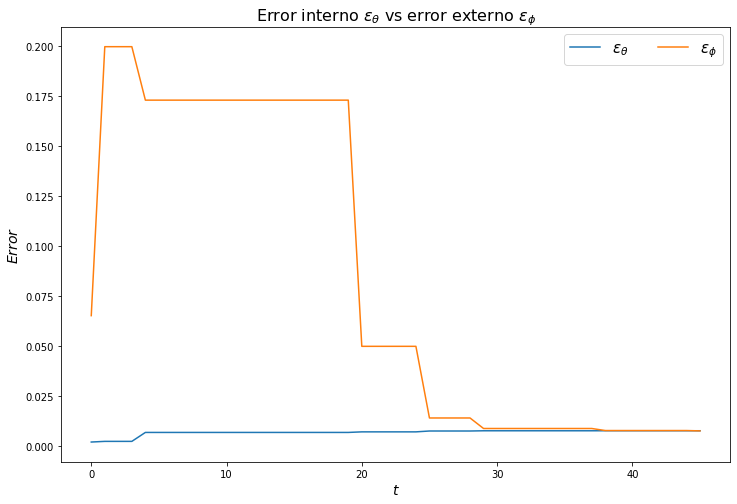

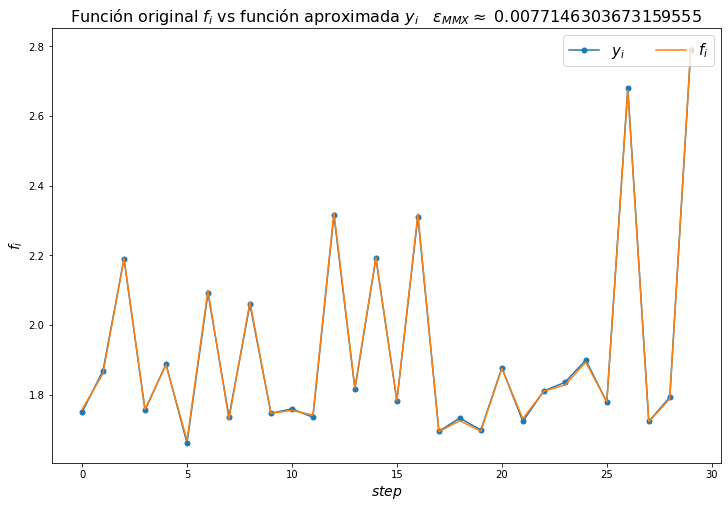

*** RESULTADOS ***
Emmx:  0.0077146303673159555
C_000 = 0.35846842442249155
C_001 = 0.7886854937239525
C_010 = -1.0235249392442833
C_011 = 0.22569816222170175
C_100 = -0.34128627143225815
C_101 = 1.2753225751742365
C_110 = -0.06461909588980067
C_111 = 0.022363699414524138

Tiempo de ejecución: 0.01994633674621582 s


In [11]:
solution,residuals = NAA('1_Examen Alonso.txt',[1,1,1],initial_Mequidistant=False,method='det')

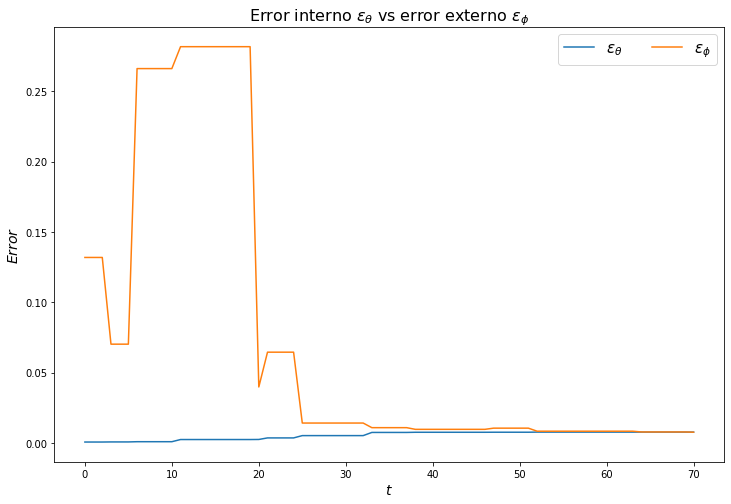

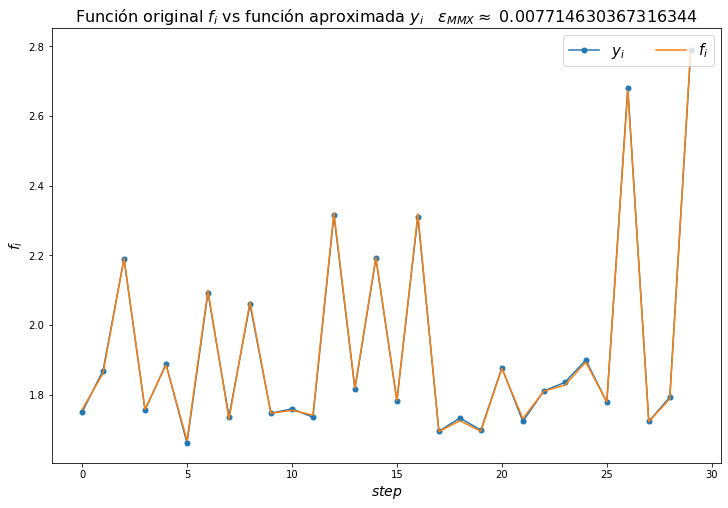

*** RESULTADOS ***
Emmx:  0.007714630367316344
C_000 = 0.35846842442249355
C_001 = 0.7886854937239605
C_010 = -1.023524939244282
C_011 = 0.2256981622217037
C_100 = -0.3412862714322558
C_101 = 1.2753225751742427
C_110 = -0.06461909588979965
C_111 = 0.02236369941452455

Tiempo de ejecución: 0.026928186416625977 s


In [12]:
solution,residuals = NAA('1_Examen Alonso.txt',[1,1,1],initial_Mequidistant=True,method='det')

### Método de proponer el signo de un cofactor en -1 y resolver el SE

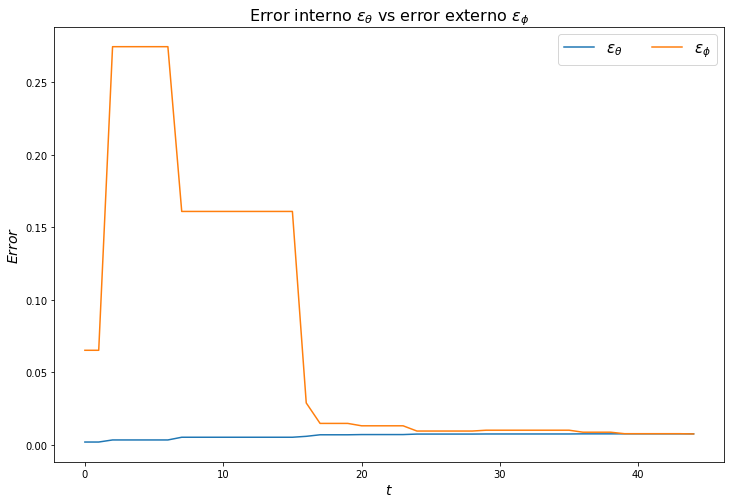

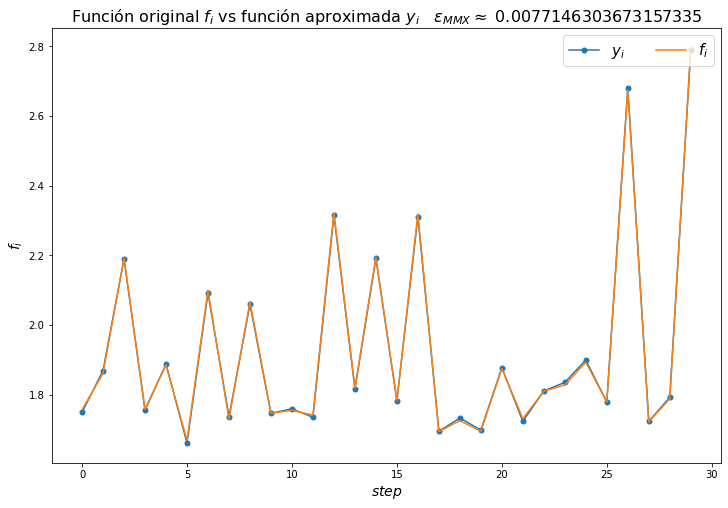

*** RESULTADOS ***
Emmx:  0.0077146303673157335
C_000 = 0.35846842442249394
C_001 = 0.7886854937239577
C_010 = -1.023524939244284
C_011 = 0.22569816222170241
C_100 = -0.34128627143225565
C_101 = 1.275322575174241
C_110 = -0.06461909588980057
C_111 = 0.022363699414524145

Tiempo de ejecución: 0.012993097305297852 s


In [13]:
solution,residuals = NAA('1_Examen Alonso.txt',[1,1,1],initial_Mequidistant=False,method='indirect_COT')

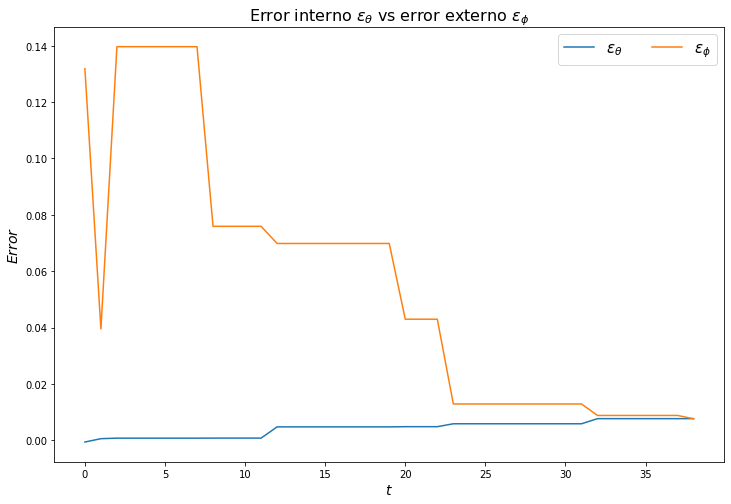

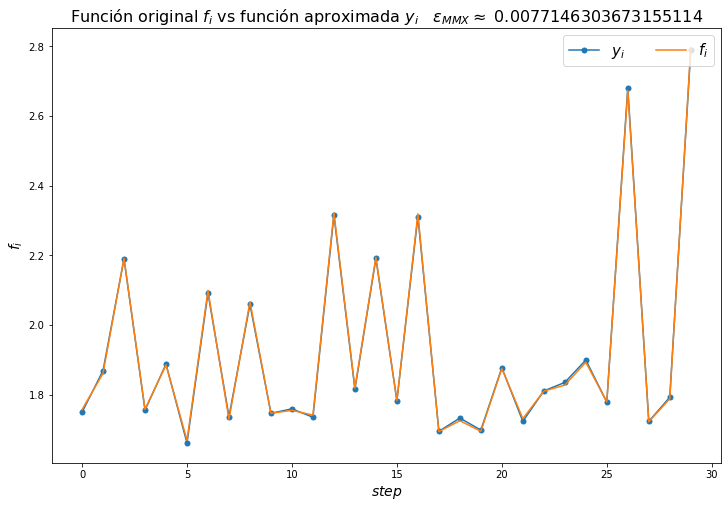

*** RESULTADOS ***
Emmx:  0.0077146303673155114
C_000 = 0.3584684244224007
C_001 = 0.7886854937238578
C_010 = -1.0235249392442616
C_011 = 0.22569816222169886
C_100 = -0.34128627143230544
C_101 = 1.2753225751741737
C_110 = -0.06461909588979839
C_111 = 0.022363699414525245

Tiempo de ejecución: 0.011968374252319336 s


In [14]:
solution,residuals = NAA('1_Examen Alonso.txt',[1,1,1],initial_Mequidistant=True,method='indirect_COT')

## Ejercicio 2

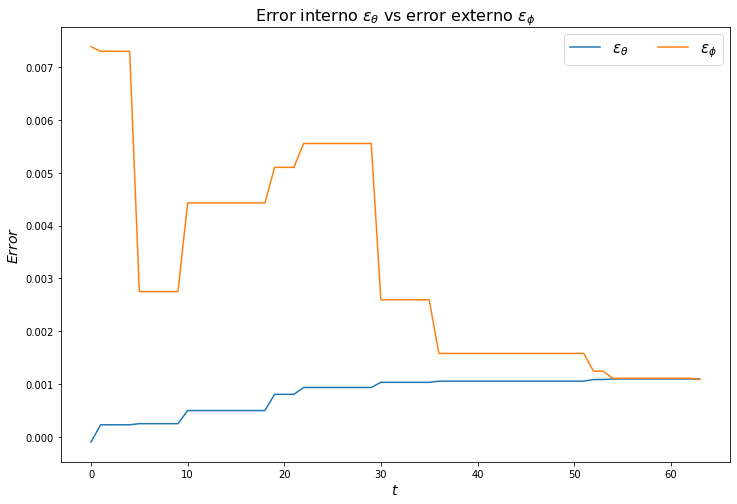

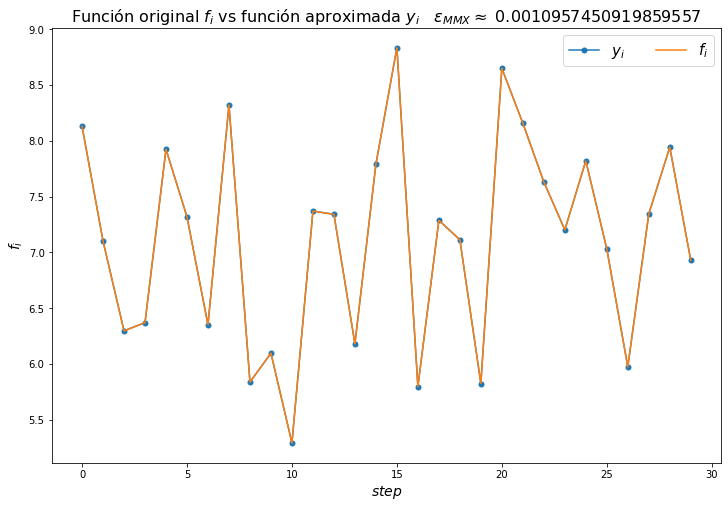

*** RESULTADOS ***
Emmx:  0.0010957450919859557
C_000 = 1.2952890658301957
C_001 = 3980.078666235426
C_010 = 3980.8377955424694
C_011 = 0.02087084927649792
C_100 = -3981.1084936434872
C_101 = -7961.245921454982
C_110 = 0.021009788211008632
C_111 = 0.0030388723544244756

Tiempo de ejecución: 0.023936033248901367 s


In [15]:
solution,residuals = NAA('1_Examen Bandala.txt',[1,1,1],initial_Mequidistant=False,method='det')

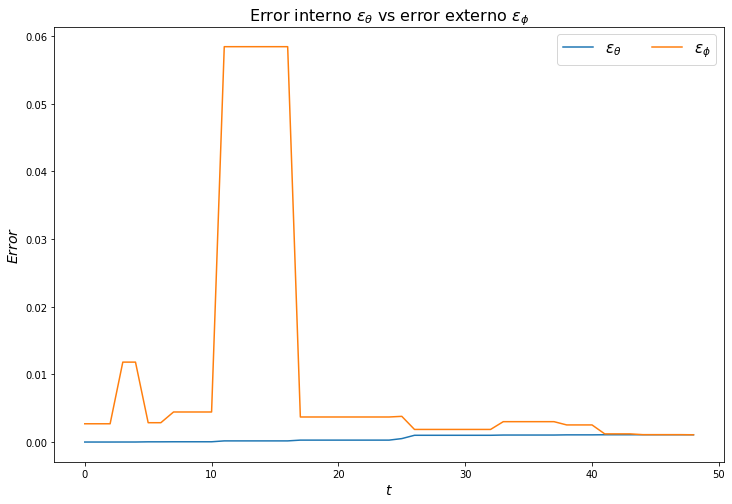

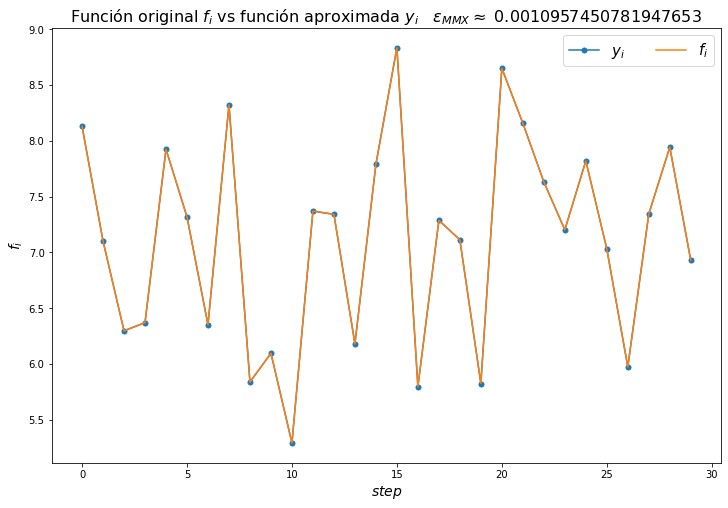

*** RESULTADOS ***
Emmx:  0.0010957450781947653
C_000 = 1.2952890663852863
C_001 = 3980.0761500822327
C_010 = 3980.835279389071
C_011 = 0.020870849237533757
C_100 = -3981.1059774904506
C_101 = -7961.240889148606
C_110 = 0.02100978817503175
C_111 = 0.0030388723465780256

Tiempo de ejecución: 0.01997518539428711 s


In [16]:
solution,residuals = NAA('1_Examen Bandala.txt',[1,1,1],initial_Mequidistant=True,method='det')

### Método de proponer el signo de un cofactor en -1 y resolver el SE

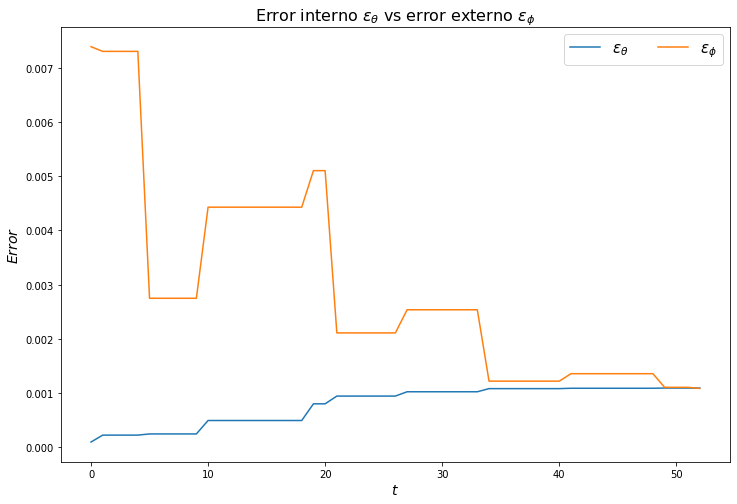

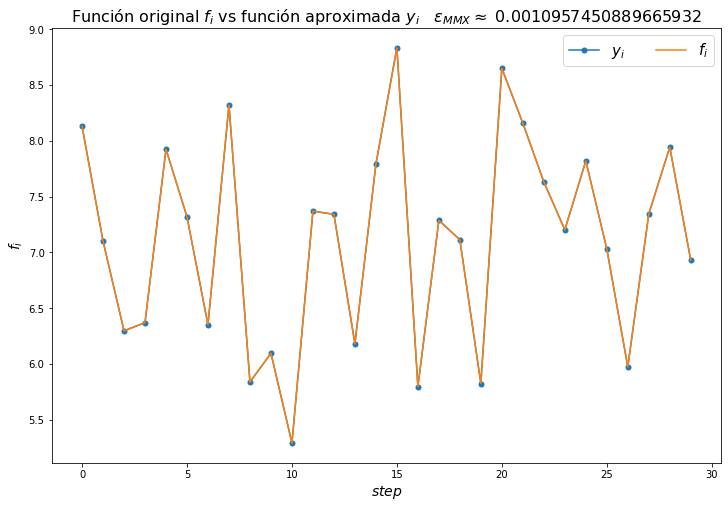

*** RESULTADOS ***
Emmx:  0.0010957450889665932
C_000 = 1.2952890658713436
C_001 = 3980.0786609916636
C_010 = 3980.837790298688
C_011 = 0.020870849278228853
C_100 = -3981.1084883996714
C_101 = -7961.245910967388
C_110 = 0.021009788213075246
C_111 = 0.003038872354759804

Tiempo de ejecución: 0.014960289001464844 s


In [17]:
solution,residuals = NAA('1_Examen Bandala.txt',[1,1,1],initial_Mequidistant=False,method='indirect_COT')

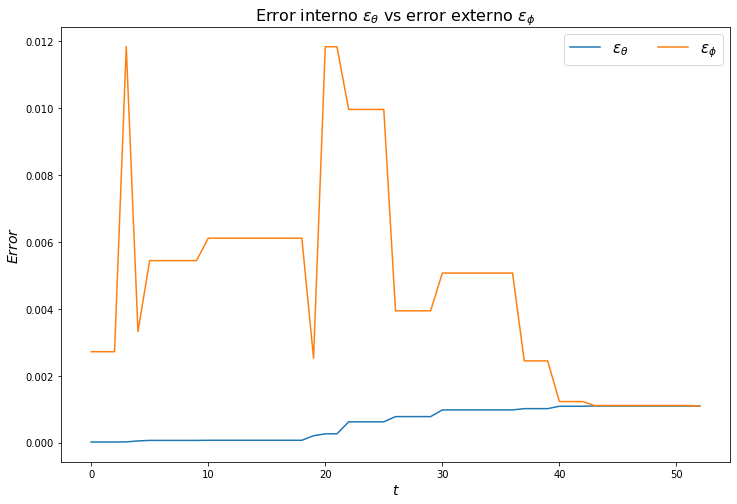

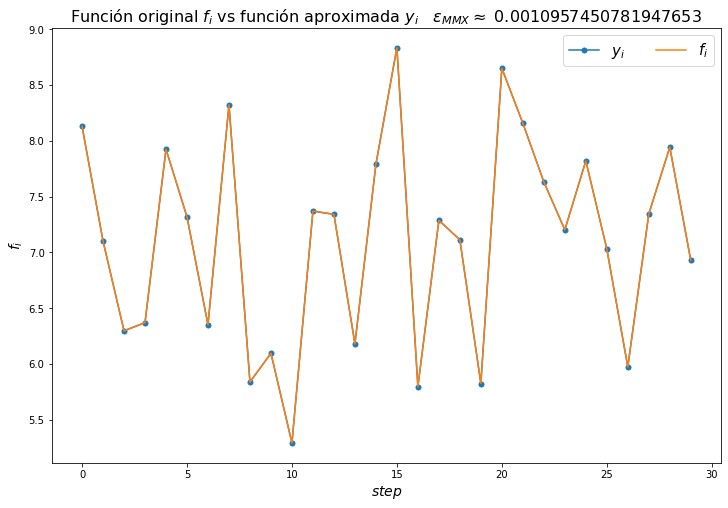

*** RESULTADOS ***
Emmx:  0.0010957450781947653
C_000 = 1.2952890663852863
C_001 = 3980.0761500822327
C_010 = 3980.835279389071
C_011 = 0.020870849237533757
C_100 = -3981.1059774904506
C_101 = -7961.240889148606
C_110 = 0.02100978817503175
C_111 = 0.0030388723465780256

Tiempo de ejecución: 0.01595783233642578 s


In [18]:
solution,residuals = NAA('1_Examen Bandala.txt',[1,1,1],initial_Mequidistant=True,method='indirect_COT')

## Resumen de resultados

En la siguiente tabla se muestran los resultados de ejecutar el algoritmo cambiando un par de cosas, la bandera de inicializar el conjunto interno con los $M$ vectores equidistantes y el método para solucionar los signos $\sigma_i$.

|Examen|M equidistante|Método|Pasos|Tiempo [s]|
|:--------:|:--------:|:--------:|:--------:|:--------:|
Alonso | False | det | 45 | 0.019 |
Alonso | True | det | 70 | 0.029 |
Alonso | False | indirect_COT | 44 | 0.014 |
Alonso | True | indirect_COT | 38 | 0.013 |
Bandala | False | det | 63 | 0.026 |
Bandala | True | det | 48 | 0.021 |
Bandala | False | indirect_COT | 52 | 0.016 |
Bandala | True | indirect_COT | 52 | 0.016 |

Se observa que utilizar el método de proponer el signo de $\sigma_m = -1$ y después resolver el sistema de ecuaciones para obtener los signos y el valor de los $m$ coeficientes, en comparación a resolver de forma explícita los signos de cada determinante toma más tiempo.

## Ejecución del archivo .py

Para ejecutar el programa es necesario ejecutar el programa __NaiveAscentAlgorithm.py__, el cual le pedirá al usuario los parámetros _data_path_, _degree_variables_, _initial_Mequidistant_ y _method_:

- _Ingresa la ruta del archivo:_ El usuario debe ingresar la dirección del archivo ya sea en formato _csv_ o _txt_.
- _Ingresa el tipo de separador (, o tab):_ El usuario debe ingresar ',' en caso de que la separación de los datos sea con coma o 'tab' si es por tabulador. Una vez ingresado se guarda en la variable
- _Ingresa la lista con el grado maximo de variables. Ejemplo:[1,1,1]:_ El usuario debe de ingresar una lista con el formato especificado con el grado máximo de las variables con las que se quiere aproximar.
- _Desea inicializar el vector M equidistante (y/n):_ EL usuario debe ingresa 'y' si quiere inicializar el conjunto interno con los $M$ vectores equidistantes, en caso contrario debe ingresa 'n'.
- _Ingrese el metodo por el que se quiere resolver los signos (det/indirect_COT):_ El usuario debe ingresar el método por el cual se obtienen los signos $\sigma_i$ en el sistema de ecauciones. Ya sea 'det' (cálculo explícito) o 'indirect_COT' (cálculo indirecto utilizando COT).

Después de que el usuario ingresa los parámetros de manera correcta se ejecuta el programa principal (función __NAA__), una vez finalizado se muestran las gráficas de los errores y la comparación de los resultados obtenidos, se imprime en consola el valor del $\epsilon_{RMS}$, los coeficientes $c_i$ y el tiempo de ejecución. Además se guardan en el directorio local dos archivos _txt_, el primero de nombre _solution.txt_ que guarda el vector con el $\epsilon_{RMS}$ y los coeficientes $c_i$, y el otro archivo se llama _yi.txt_ que contiene los valores obtenidos del poinomio minimax.

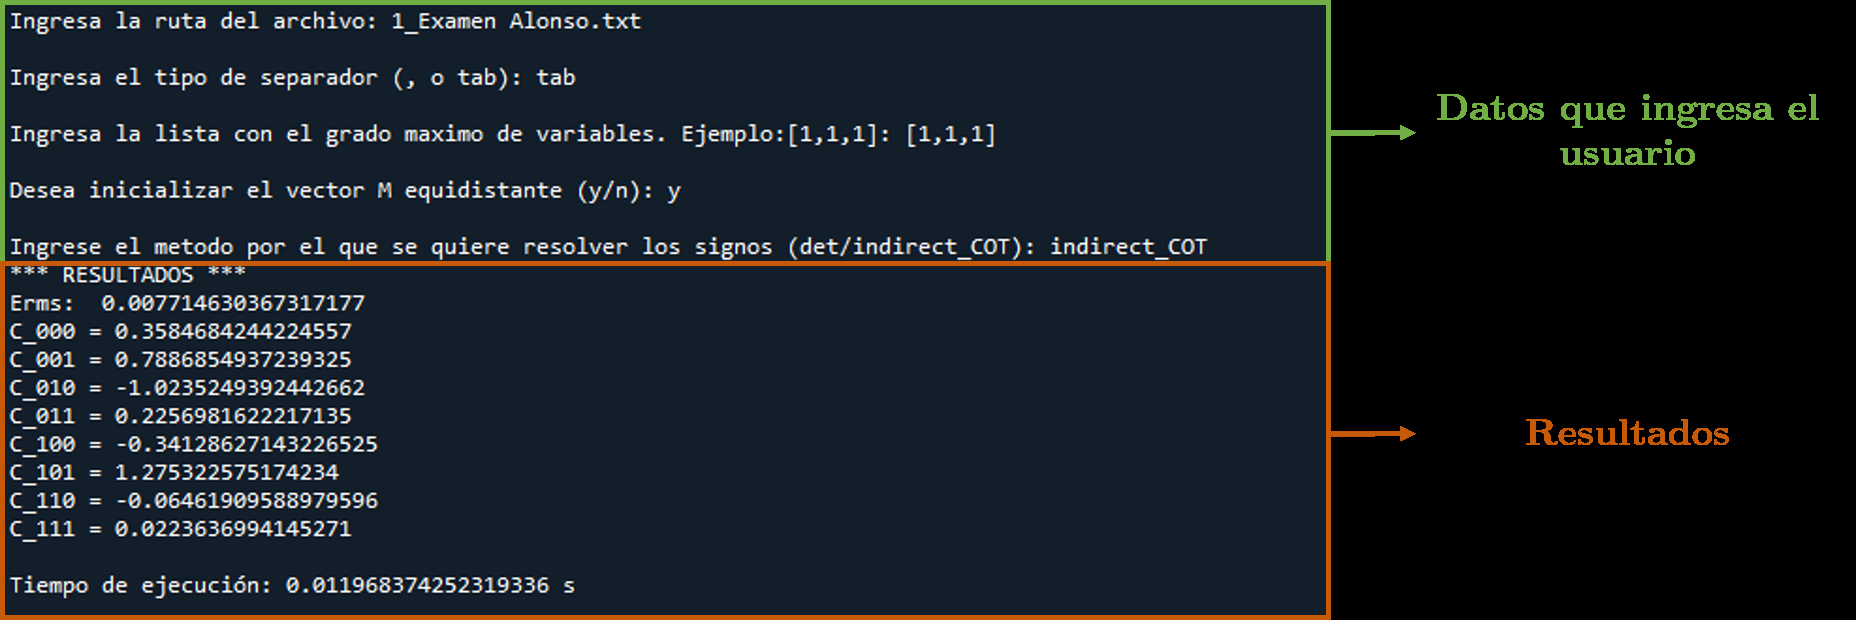